
## Create spark session in pyspark, read CSV ##


In [1]:
from pyspark.sql import SparkSession

In [2]:
from pyspark.conf import SparkConf

In [3]:
from pyspark.sql.functions import col,asc,desc,lit,instr,regexp_replace

In [4]:
from pyspark.sql.types import IntegerType

In [5]:
c= SparkConf()

In [6]:
spark = SparkSession.builder.master("local").config(conf=c).appName("Claims").enableHiveSupport().getOrCreate()

In [7]:
df = spark.read.option("header","true").option("InferSchema","True").csv(r'C:\Users\sunil.dabbiru\Downloads\ClaimResults.csv')

In [8]:
df.show(10)

+-------------------+--------+--------+--------+--------+---------+--------+
|               WEEK| INITIAL|INIT_PCT|REOPENED|REOP_PCT|CONTINUED|CONT_PCT|
+-------------------+--------+--------+--------+--------+---------+--------+
|15: {04/11 - 04/17}|   5,627| -65.82%|   3,097| -62.99%|  277,331| -18.53%|
|14: {04/04 - 04/10}|  16,461| -28.91%|   8,367| -12.76%|  340,413|  -2.74%|
|13: {03/28 - 04/03}|  23,156|   1.28%|   9,591|  -9.36%|  350,015|  -1.55%|
|12: {03/21 - 03/27}|  22,864|  17.89%|  10,582|  -1.39%|  355,518|  -5.19%|
|11: {03/14 - 03/20}|  19,394|  59.85%|  10,731| -19.35%|  374,981|  -4.61%|
|10: {03/07 - 03/13}|  12,133|   1.74%|  13,305|  36.88%|  393,121|  -1.84%|
| 9: {02/28 - 03/06}|  11,925|   27.2%|   9,720| -11.96%|  400,472|     -3%|
| 8: {02/21 - 02/27}|   9,375|   5.54%|  11,041|  -22.4%|  412,845|   1.11%|
| 7: {02/14 - 02/20}|   8,883| -21.54%|  14,229| -35.42%|  408,315|  -1.62%|
| 6: {02/07 - 02/13}|  11,322| -17.44%|  22,032|  12.35%|  415,058|   4.26%|

In [9]:
df.dtypes

[('WEEK', 'string'),
 ('INITIAL', 'string'),
 ('INIT_PCT', 'string'),
 ('REOPENED', 'string'),
 ('REOP_PCT', 'string'),
 ('CONTINUED', 'string'),
 ('CONT_PCT', 'string')]

In [10]:
df.createOrReplaceTempView("Claims")

In [11]:
df2021 =spark.sql("select int(substr(WEEK,1,instr(WEEK,':')-1)) as WEEK_NU,rank() over (partition by substr(WEEK,1,instr(WEEK,':')-1) order by monotonically_increasing_id()) as r,case when substr(WEEK,1,instr(WEEK,':')-1) <=15 then 2021 else 2020 end as YEAR,int(replace(INITIAL,',','')) as INITIAL,WEEK from Claims c").select("YEAR","WEEK","INITIAL","WEEK_NU").where("r =1").where("YEAR=2021").orderBy(col("WEEK_NU").desc())

In [12]:
df2021.columns

['YEAR', 'WEEK', 'INITIAL', 'WEEK_NU']

In [13]:
df2021_2 = df2021.select('WEEK', 'INITIAL')

In [14]:
df_2 = df.select('WEEK', 'INITIAL').withColumn("INITIAL",regexp_replace(col("INITIAL") , ",","").cast(IntegerType()))

In [15]:
df_2.dtypes

[('WEEK', 'string'), ('INITIAL', 'int')]

In [16]:
df2020_1 = df_2.subtract(df2021_2)

In [17]:
df2020 = df2020_1.withColumn("YEAR",lit(2020)).withColumn("WEEK_NU",col("WEEK").substr(lit(1),instr(col("WEEK"),":")-1)).withColumn("WEEK_NU",col("WEEK_NU").cast(IntegerType())).orderBy(col("WEEK_NU").desc())

### Convert spark dataframe to pandas df and vice versa ###

In [18]:
import pandas as pd

In [19]:
import numpy as np

### Removing the latest week since it is start of the week ###

In [20]:
pdf = df2021.where(col("WEEK_NU") != 15).toPandas()

In [21]:
df1 = spark.createDataFrame(pdf)

### Plot dataframe for 2021 claims ###

In [22]:
import matplotlib.pyplot as plt

In [23]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [24]:
fig.suptitle('Initial Claims vs weeks',fontsize =10)

Text(0.5, 0.98, 'Initial Claims vs weeks')

In [25]:
ypoints = pdf['INITIAL'].astype(int)

In [26]:
xpoints = pdf['WEEK_NU']

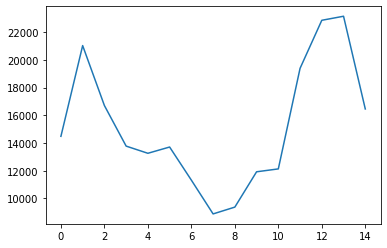

In [27]:
plt.plot(xpoints,ypoints)

### Plot dataframe for 2020 claims ###

In [28]:
pdf2020 = df2020.toPandas()

In [29]:
ypoints = pdf2020['INITIAL'].astype(int)

In [30]:
xpoints = pdf2020['WEEK_NU'].astype(int)

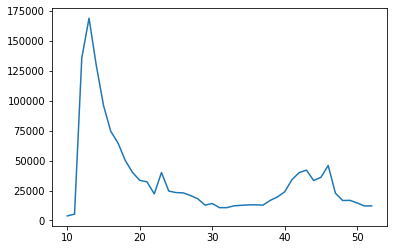

In [31]:
plt.plot(xpoints,ypoints)

In [32]:
import seaborn as sns

In [33]:
df2020.dtypes

[('WEEK', 'string'), ('INITIAL', 'int'), ('YEAR', 'int'), ('WEEK_NU', 'int')]

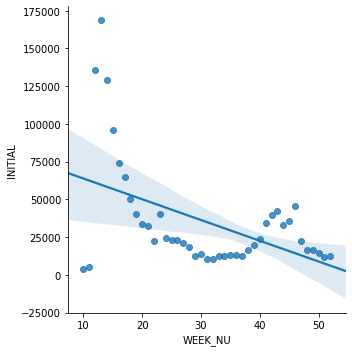

In [34]:
sns.lmplot(x='WEEK_NU',y='INITIAL',data=pdf2020)

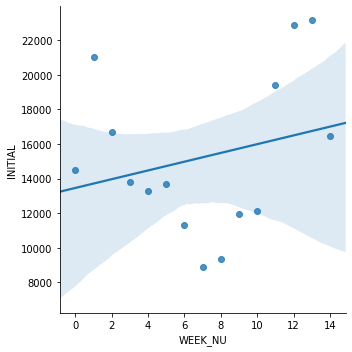

In [60]:
sns.lmplot(x='WEEK_NU',y='INITIAL',data=pdf,fit_reg=True)

In [51]:
concatenated = pd.concat([pdf2020.assign(dataset='pdf2020'),pdf.assign(dataset='pdf')],sort=True)

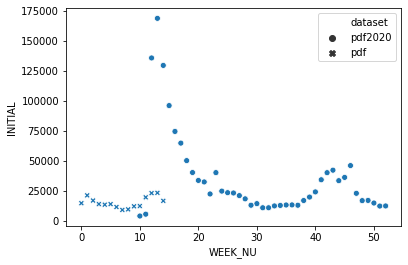

In [52]:
sns.scatterplot(x='WEEK_NU',y='INITIAL',data=concatenated,style='dataset')

#### Todo: Add trendlne ,check outliers , Linear Regression : get R^2 , slope , intercept , y = MX + c ####
